In [51]:
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

%matplotlib inline

# Eigenfaces

Principal Component Analysis captures the variance of a set of data in a very convenient form. In this notebook, you will implement Eigenfaces: a facial recognition framework based on PCA. The idea is that the most important variances will be represented by the eigenvectors of the covariance matrix of faces.

## Loading the Data

The first task is to load and visualize the data. Luckily, code has already been provided for this. You will need to change `data_dir` to point to the location of the extracted dataset that was downloaded from Canvas.

In [52]:
# Load raw images
data_dir = "/Users/nabelio/Downloads/ATTfaces/faces/"
file_names = os.listdir(data_dir)
images = [np.asarray(Image.open(data_dir + file_names[i])) for i in range(len(file_names))]
images = np.array(images)

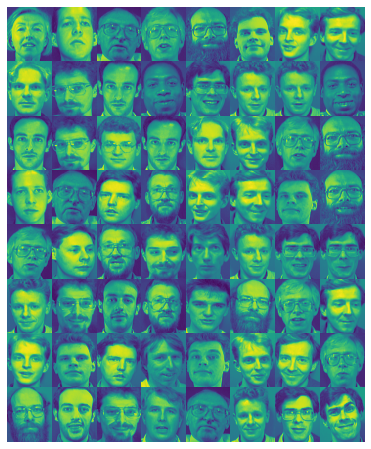

In [53]:
# Visualize some of the faces
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0)

for ax, im in zip(grid, images[:64]):
    ax.imshow(im)
    ax.axis('off')

# Principal Component Analysis

Eigenfaces is a technique based on PCA that allows for image compression, face detection, and face recognition. In this assignment, you will be filling in the relevant code to view how images are reconstructed using the eigenfaces.

This method is implemented in the following steps:
1. Compute the mean face image of your dataset. This can be done simply via `numpy`.
2. Compute the eigenfaces (eigenvectors) of your dataset. There are two ways to accomplish this that we have covered in class. The first option is to use SVD. The $U$ matrix represents the normalized eigenvectors. A second option is to perform eigendecomposition on the covariance matrix. This method is detailed below.
3. Finally, the weights for each image are calculated. These weights indicate how much of each principle component contribute to the image.

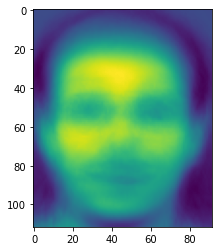

In [54]:
# Calculate the mean face
# face_mean = # TODO: Fill in the code to get the mean face image
face_mean = images.mean(0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(face_mean)

# Performing Eigendecomposition

There are 400 images with resolution 92 x 112. To calculate a covariance matrix, you'll need to reshape the images so that each one is a 10304-dimensional vector. This covariance matrix is divided by 1 less than the number of samples:

\begin{equation*}
C = \frac{1}{n-1} X^T X
\end{equation*}

Now we can easily compute a covariance matrix, right?

## Computational Complexity of $X^T X$

The covariance matrix of a dataset with 10304 features will be $10304 \times 10304$. This will take a long time to compute. **Instead, we will compute the covariance matrix of the 400 samples. This yields a $400 \times 400$ matrix.**

**How do the eigenvectors of the $400 \times 400$ covariance matrix relate to the $10304 \times 10304$ matrix?**

Let $X \in \mathbb{R}^{10304 \times 400}$. Then $P = X^T X \in \mathbb{R}^{400 \times 400}$ and $C = X X^T \in \mathbb{R}^{10304 \times 10304}$. If $\mathbf{v}_i$ is an eigenvector of $P$ then $P\mathbf{v}_i = \lambda_i \mathbf{v}_i$, and

\begin{align*}
    X P \mathbf{v}_i &= \lambda_i X \mathbf{v}_i\\
    X X^T X \mathbf{v}_i &= \lambda_i X \mathbf{v}_i\\
    C X \mathbf{v}_i &= \lambda_i X \mathbf{v}_i
\end{align*}

If we let $\mathbf{u}_i = X \mathbf{v}_i$, then $\mathbf{u}_i$ and $\lambda_i$ are the 400 eigenvectors and eigenvalues of $C$.

For reconstruction purposes, normalize each $\mathbf{u}_i$ (or each eigenface).

**Fill in the function below. It should return the eigenfaces and weights of your dataset.**

In [55]:
num_images, height, width = images.shape

def compute_pca(data, data_mean):
    # 1. Subtract the mean image from all images
    images_sub = images - face_mean

    # 2. Vectorize the images to a 400 x 10304 matrix -- use reshape

    X = images_sub.reshape(num_images, -1)
    # 3. Create the covariance matrix -- don't forget to divide by 1 less than the number of samples

    X_cov = 1 / (num_images - 1) * (X @ X.T)
    # 4. Compute the eigendecomposition -- try np.linalg.eig

    D,V = np.linalg.eig(X_cov)
    sort_idx = D.argsort()[::-1]
    D = D[sort_idx]
    V = V[:,sort_idx]
    # 5. Calculate the eigenfaces: U = XV -- you may have to multiply these differently based on the shape

    eigenfaces = V.T @ X
    # 6. Normalize the eigenfaces to that they are unit vectors -- np.lingalg.norm helps here!
    
    eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=1)[:, np.newaxis]
    # 7. Compute the weights by projected the centered data onto the eigenfaces
    
    weights = X @ eigenfaces.T
    # 8. Return the normalized eigenfaces and weights
    return eigenfaces, weights

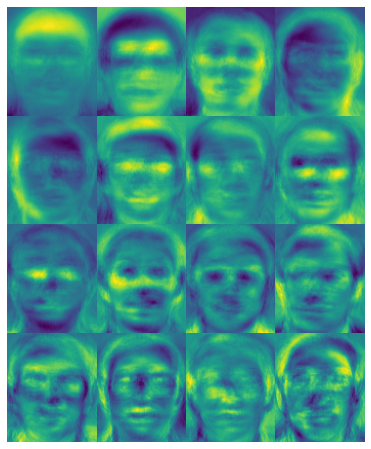

In [56]:
# Compute PCA and visualize
eigenfaces, weights = compute_pca(images, face_mean)

# Visualize some eigenfaces
fig = plt.figure(figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0)

for ax, im in zip(grid, eigenfaces[:16]):
    ax.imshow(im.reshape(height, width))
    ax.axis('off')

# Eigenfaces as a form of compression

We can reconstruct the original images from the eigenfaces. This is accomplished by taking the mean image of the dataset and adding the eigenfaces scaled by the weights calculated in `compute_pca`:

\begin{equation*}
    \mathbf{x}_{r} = \mathbf{x}_{mean} + \sum_{i=0}^{M-1} w_{i}\mathbf{u}_i
\end{equation*}

In [57]:
def reconstruct(weights, eigenfaces, X_mean, img_size, img_idx, n_comps=400):
    """TODO: Reconstruct the image given by `img_idx` using `n_comps` eigenfaces.
    Don't forget to reshape the image so that it is no longer a vector!
    """
    h,w = img_size
    print(weights.shape, eigenfaces.shape, X_mean.shape)
    recovered_img = X_mean.copy() + (weights[img_idx, :n_comps] @ eigenfaces[:n_comps, :])
    return recovered_img.reshape(h,w)

# Visualizing the Reconstruction

Congratulations! You've made it! The last step is to check out your work by visualizing how good the reconstructed image is based on the number of eigenfaces used during reconstruction. Play around with `img_idx` and `n_comps` below to select a different image and different number of principle components.

(400, 400) (400, 10304) (10304,)


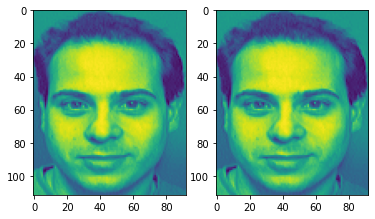

In [59]:
img_idx = 200
n_comps = 400

recovered_img = reconstruct(weights, eigenfaces, face_mean.reshape(-1), [height, width], img_idx, n_comps)

# Visualize original and reconstructed
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(images[img_idx])
ax2.imshow(recovered_img)